In [701]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

In [702]:
# Global Parameters
R = 0.082057 # L·atm/(mol·K)
cpCO2 = 37.1; cpH2 = 28.8; cpAr = 35.3; cpCO = 29.1; cpH2O = 33.6; cpCH4 = 20.8

In [703]:
# Reactor Configurations
L = 40 # cm
ID = 0.052 # cm
A = np.pi * (ID/2)**2 # cm^2
nx = 201
z_span = (0, L)
z_eval = np.linspace(0, L, nx)

In [704]:
# Indicator position
id_value = [2, 3.3, 4.9, 6.8, 9, 11.5, 14.3, 17.4, 22.6, 25.7, 28.5, 31, 33.2, 35.1, 36.7, 38]
id_idx = [np.argmin(np.abs(z_eval - v)) for v in id_value]
id_idx

[np.int64(10),
 np.int64(16),
 np.int64(24),
 np.int64(34),
 np.int64(45),
 np.int64(57),
 np.int64(71),
 np.int64(87),
 np.int64(113),
 np.int64(128),
 np.int64(142),
 np.int64(155),
 np.int64(166),
 np.int64(175),
 np.int64(183),
 np.int64(190)]

In [705]:
# Feed Conditions
P = 1 # atm
Fv_st = 89.4 # mL/min
Fi = P*Fv_st/1000/60/R/298.15 # mol/s

Ti = 473.15 # K
rhoi = P/R/Ti # mol/L
zi_CO2 = 0.24; zi_H2 = 0.72; zi_Ar = 0.04; zi_CO = 0; zi_H2O = 0; zi_CH4 = 0
Ci_CO2 = rhoi * zi_CO2; Ci_H2 = rhoi * zi_H2; Ci_Ar = rhoi * zi_Ar; Ci_CO = rhoi * zi_CO; Ci_H2O = rhoi * zi_H2O; Ci_CH4 = rhoi * zi_CH4
cp_CO2 = 37.1; cp_H2 = 28.8; cp_Ar = 35.3; cp_CO = 29.1; cp_H2O = 33.6; cp_CH4 = 20.8
Fvi = Fi/rhoi*1000 #mL/s 
Vi = Fvi/A # cm/s

In [706]:
# Initial Conditions
var0 = [Vi, rhoi ,Ci_CO2, Ci_H2, Ci_CO, Ci_CH4, Ci_H2O, Ci_Ar,Ti]

# Source term
Qa = -1.5
Qb = 30
k0 = 1e6
k1 = 1e6
k2 = 1e6

Ea0 = 110000
Ea1 = 97100
Ea2 = 77820

Hr0 = 41000/1000
Hr1 = -165000/1000
Hr2 = 247300/1000

In [707]:
def pfr_ode(z, y):
    V, rho, CO2, H2, CO, CH4, H2O, Ar, T = y
    
    # 총 농도 계산 (현재 상태)
    total_conc = CO2 + H2 + CO + CH4 + H2O + Ar
    
    # 몰분율 계산 (농도 기준)
    zCO2 = CO2 / total_conc
    zH2 = H2 / total_conc
    zCO = CO / total_conc
    zCH4 = CH4 / total_conc
    zH2O = H2O / total_conc
    zAr = Ar / total_conc

    # 부분압 계산 (이상기체 법칙: p_i = y_i * P)
    pCO2 = zCO2 * P; pH2 = zH2 * P; pCO = zCO * P; pCH4 = zCH4 * P; pH2O = zH2O * P; pAr = zAr * P
    
    # 비열 계산 (몰분율 기준 혼합)
    cp = zCO2*cpCO2 + zH2*cpH2 + zCO*cpCO + zCH4*cpCH4 + zH2O*cpH2O + zAr*cpAr

    # 반응속도 계산 (Arrhenius equation)
    r0 = k0 * np.exp(-Ea0/8.314/T) * pCO2 * pH2        # CO2 + H2 → CO + H2O
    r1 = k1 * np.exp(-Ea1/8.314/T) * pCO2 * pH2**4     # CO2 + 4H2 → CH4 + 2H2O
    r2 = k2 * np.exp(-Ea2/8.314/T) * pCH4 * pCO2       # CH4 + CO2 → 2CO + 2H2

    # 이상기체 상태방정식에 의한 현재 밀도
    rho = P / (R * T)  # mol/L
    
    # 총 몰수 변화율 계산 (반응 화학량론)
    # r0: CO2 + H2 → CO + H2O (몰수 변화 = 0)
    # r1: CO2 + 4H2 → CH4 + 2H2O (몰수 변화 = -2)
    # r2: CH4 + CO2 → 2CO + 2H2 (몰수 변화 = +2)
    total_mole_change_rate = (-2*r1 + 2*r2) / V
    
    # 연속방정식: d(ρV*A)/dz = 총 몰수 변화율 * A
    # ρV = 질량유량/A이므로, d(ρV)/dz = (1/A) * d(질량유량)/dz
    # 온도 변화에 따른 밀도 변화: dρ/dT = -P/(RT²)
    drho_dT = -P / (R * T**2)
    Q = Qa*z + Qb
    dTdz = (Q -  Hr0*r0 - Hr1*r1 - Hr2*r2) / (rho/1000 * cp * V)
    
    # 총 밀도 변화율: 반응에 의한 변화 + 온도에 의한 변화
    drhodz = total_mole_change_rate + drho_dT * dTdz
    
    # 연속방정식: d(ρV)/dz = 0 → dV/dz = -(V/ρ) * dρ/dz
    dVdz = -(V / rho) * drhodz

    # 물질수지 방정식 (연속방정식 효과 포함)
    # dC_i/dz = 반응항/V - C_i * (1/V) * dV/dz
    convection_term = (1/V) * dVdz

    
    dCO2dz = (-r0 - r1 - r2) / V - CO2 * convection_term
    dH2dz = (-r0 - 4*r1 + 2*r2) / V - H2 * convection_term
    dCOdz = (r0 + 2*r2) / V - CO * convection_term
    dCH4dz = (r1 - r2) / V - CH4 * convection_term
    dH2Odz = (r0 + 2*r1) / V - H2O * convection_term
    dArdz = 0 - Ar * convection_term  # 불활성이지만 convection 효과는 있음

    # 에너지 보존 방정식은 이미 계산됨
    
    return [dVdz, drhodz, dCO2dz, dH2dz, dCOdz, dCH4dz, dH2Odz, dArdz, dTdz]

sol = solve_ivp(pfr_ode, z_span, var0, t_eval=z_eval, method='LSODA')

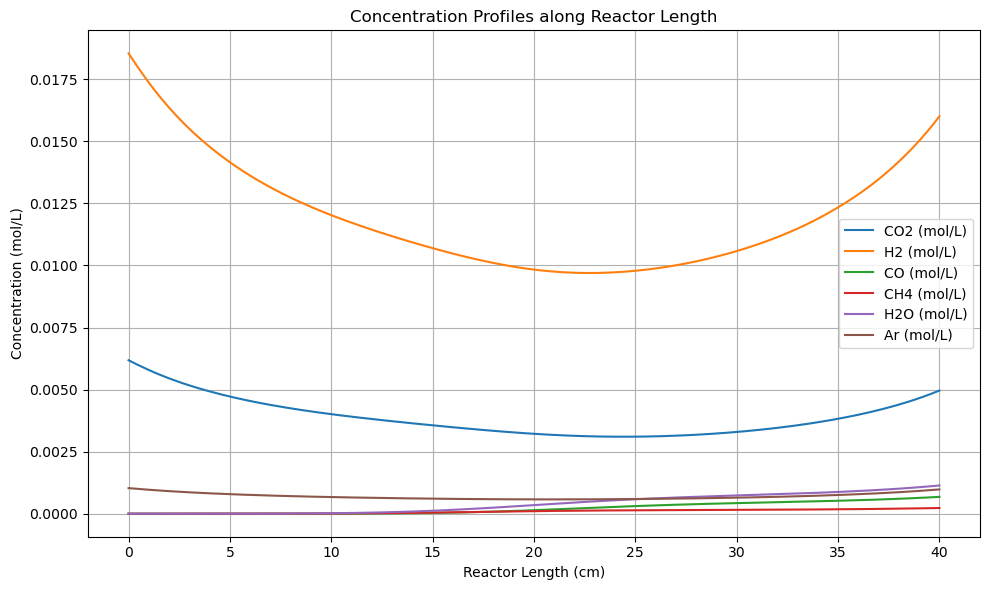

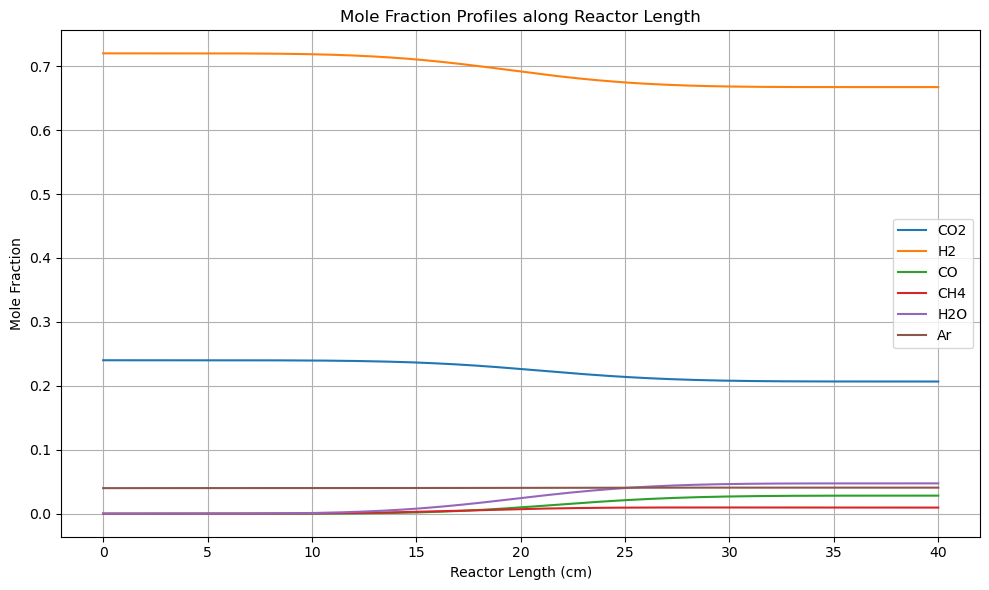

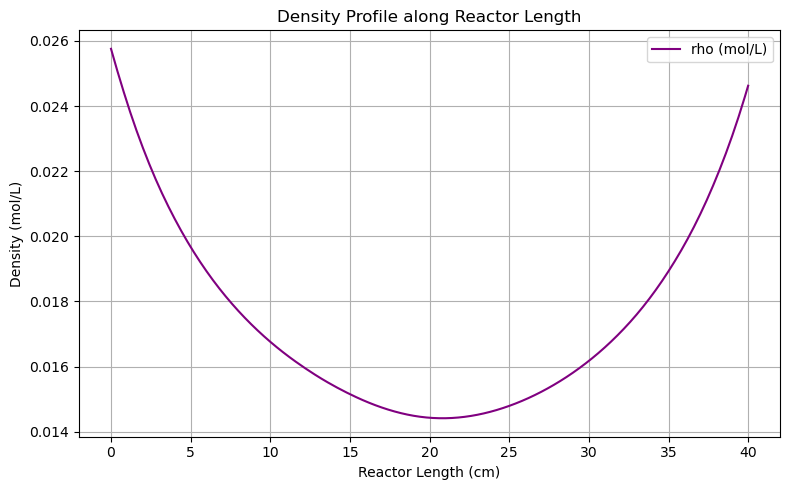

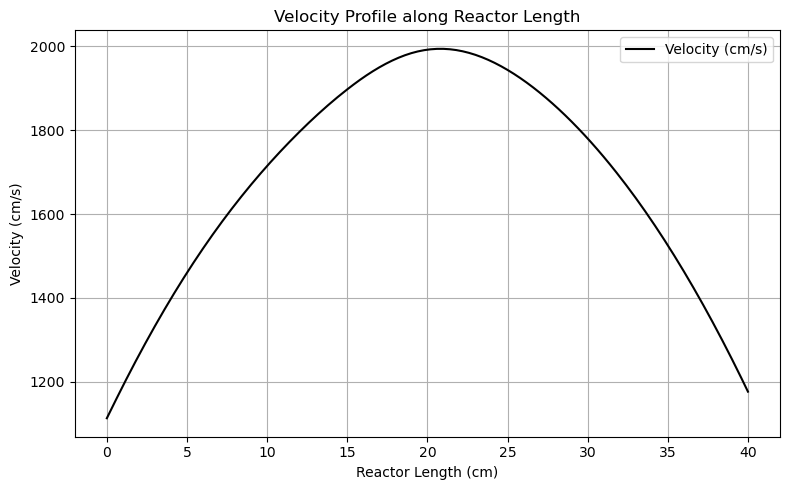

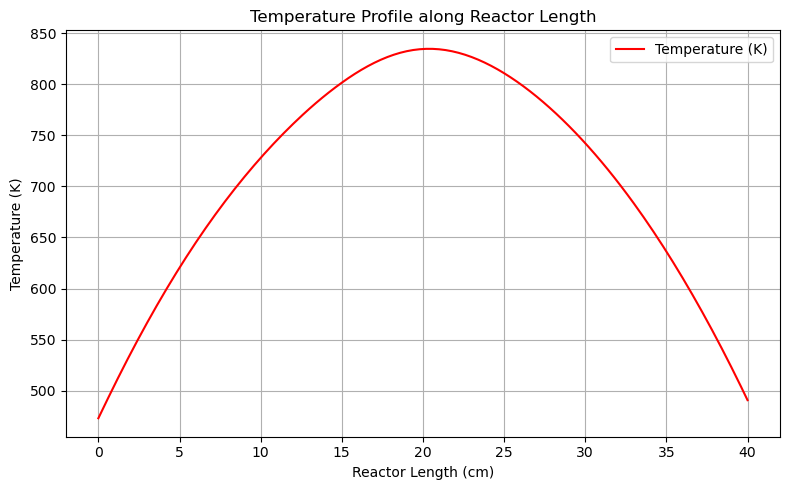

In [708]:
import matplotlib.pyplot as plt
import numpy as np

# 농도 변수만 한 번에 보여주는 그래프
concentration_labels = ['CO2 (mol/L)', 'H2 (mol/L)', 'CO (mol/L)', 'CH4 (mol/L)', 'H2O (mol/L)', 'Ar (mol/L)']
concentration_indices = [2, 3, 4, 5, 6, 7]  # sol.y에서 농도에 해당하는 인덱스 (Vi, rhoi, Ci_CO2, ... 순서임에 주의)

plt.figure(figsize=(10,6))
for idx, label in zip(concentration_indices, concentration_labels):
    plt.plot(sol.t, sol.y[idx], label=label)
plt.xlabel('Reactor Length (cm)')
plt.ylabel('Concentration (mol/L)')
plt.title('Concentration Profiles along Reactor Length')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 몰분율 계산 및 그래프
CO2 = sol.y[2]
H2 = sol.y[3]
CO = sol.y[4]
CH4 = sol.y[5]
H2O = sol.y[6]
Ar = sol.y[7]
total = CO2 + H2 + CO + CH4 + H2O + Ar

y_CO2 = CO2 / total
y_H2 = H2 / total
y_CO = CO / total
y_CH4 = CH4 / total
y_H2O = H2O / total
y_Ar = Ar / total

molefrac_labels = ['CO2', 'H2', 'CO', 'CH4', 'H2O', 'Ar']
molefrac_values = [y_CO2, y_H2, y_CO, y_CH4, y_H2O, y_Ar]

plt.figure(figsize=(10,6))
for y, label in zip(molefrac_values, molefrac_labels):
    plt.plot(sol.t, y, label=label)
plt.xlabel('Reactor Length (cm)')
plt.ylabel('Mole Fraction')
plt.title('Mole Fraction Profiles along Reactor Length')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# rho(밀도) 프로파일 추가
plt.figure(figsize=(8,5))
plt.plot(sol.t, sol.y[1], label='rho (mol/L)', color='purple')
plt.xlabel('Reactor Length (cm)')
plt.ylabel('Density (mol/L)')
plt.title('Density Profile along Reactor Length')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 속도(velocity) 프로파일 추가
plt.figure(figsize=(8,5))
plt.plot(sol.t, sol.y[0], label='Velocity (cm/s)', color='black')
plt.xlabel('Reactor Length (cm)')
plt.ylabel('Velocity (cm/s)')
plt.title('Velocity Profile along Reactor Length')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 온도 프로파일 추가
plt.figure(figsize=(8,5))
plt.plot(sol.t, sol.y[8], label='Temperature (K)', color='red')
plt.xlabel('Reactor Length (cm)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Profile along Reactor Length')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/home/sjbaek/miniforge3/envs/fdmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sjbaek/miniforge3/envs/fdmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54744 (\N{HANGUL SYLLABLE HEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sjbaek/miniforge3/envs/fdmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sjbaek/miniforge3/envs/fdmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sjbaek/miniforge3/envs/fdmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarn

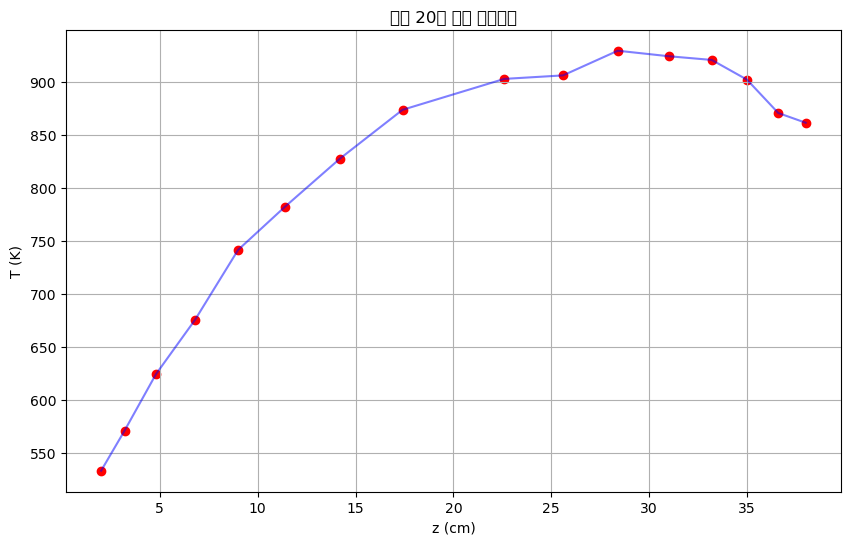

In [709]:
df = pd.read_csv('data.csv')
TI_cols = [col for col in df.columns if col.startswith('TI-')]
df[TI_cols] = df[TI_cols] + 273.15
df[TI_cols]
# 실험 번호를 입력받아 해당 실험의 온도 프로파일을 scatter로 보여주는 코드입니다.

# 실험 번호 입력 (0부터 시작)
exp_num = 20

# 입력값 검증
if exp_num < 0 or exp_num >= len(df):
    print("잘못된 실험 번호입니다.")
else:
    # 해당 실험의 TI 값 추출
    temps = df.loc[exp_num, TI_cols].values
    # 해당 위치의 z 값 추출
    z_points = [z_eval[i] for i in id_idx]
    # scatter plot
    plt.figure(figsize=(10,6))
    plt.scatter(z_points, temps, color='red')
    plt.plot(z_points, temps, color='blue', alpha=0.5)
    plt.xlabel('z (cm)')
    plt.ylabel('T (K)')
    plt.title(f'실험 {exp_num}의 온도 프로파일')
    plt.grid(True)
    plt.show()
